# Approximate q-learning

In this notebook you will teach a lasagne neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to TensorFlow almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

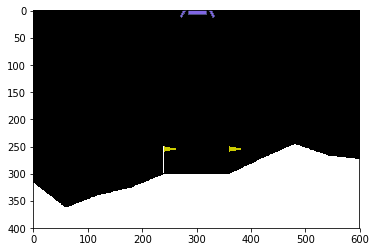

In [3]:
env = gym.make("LunarLander-v2").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

In this section we will build and train naive Q-learning with theano/lasagne

First step is initializing input variables

In [4]:
import theano
import theano.tensor as T

#create input variables. We'll support multiple states at once


current_states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
rewards = T.vector("rewards[batch]")
next_states = T.matrix("next states[batch,units]")
is_end = T.ivector("vector[batch] where 1 means that session just ended")

In [5]:
import lasagne
from lasagne.layers import *

#input layer
l_states = InputLayer((None,)+state_dim)


# <Your architecture. Please start with a single-layer network>


# nn = LSTMLayer(l_states, num_units=100, nonlinearity=lasagne.nonlinearities.rectify)
nn = DenseLayer(l_states, 100, nonlinearity=lasagne.nonlinearities.rectify)
nn = DenseLayer(nn, 50, nonlinearity=lasagne.nonlinearities.rectify)


#output layer
l_qvalues = DenseLayer(nn,num_units=n_actions,nonlinearity=None)

#### Predicting Q-values for `current_states`

In [6]:
#get q-values for ALL actions in current_states
predicted_qvalues = get_output(l_qvalues,{l_states:current_states})

In [7]:
#compiling agent's "GetQValues" function
get_qvalues = theano.function([current_states], T.argmax(predicted_qvalues, axis=1))

In [8]:
#select q-values for chosen actions
predicted_qvalues_for_actions = predicted_qvalues[T.arange(actions.shape[0]),actions]

#### Loss function and `update`
Here we write a function similar to `agent.update`.

In [9]:
#predict q-values for next states
predicted_next_qvalues = get_output(l_qvalues,{l_states:next_states})


#Computing target q-values under 
gamma = 0.99
target_qvalues_for_actions = rewards + gamma * T.max(predicted_next_qvalues, axis=1)

#zero-out q-values at the end
target_qvalues_for_actions = (1-is_end)*target_qvalues_for_actions

#don't compute gradient over target q-values (consider constant)
target_qvalues_for_actions = theano.gradient.disconnected_grad(target_qvalues_for_actions)

In [10]:

#mean squared error loss function
loss = lasagne.objectives.squared_error(predicted_qvalues_for_actions, target_qvalues_for_actions)


In [11]:
#all network weights
all_weights = get_all_params(l_qvalues,trainable=True)

#network updates. Note the small learning rate (for stability)
updates = lasagne.updates.adam(loss.mean(),all_weights,learning_rate=1e-3)

In [12]:
#Training function that resembles agent.update(state,action,reward,next_state) 
#with 1 more argument meaning is_end
train_step = theano.function([current_states, actions, rewards, next_states, is_end],
                             updates=updates, allow_input_downcast=True)

### Playing the game

In [13]:
epsilon = 0.2 #initial epsilon

def generate_session(t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        
        #get action q-values from the network
        q_values = get_qvalues(np.array([s],dtype=np.float32))[0] 
        rnd = np.random.uniform()
        if rnd < epsilon:
            a = np.random.choice(np.arange(n_actions))
        else:
            a = q_values
        
        new_s,r,done,info = env.step(a)
        
        #train agent one step. Note that we use one-element arrays instead of scalars 
        #because that's what function accepts.
        train_step(np.array([s],dtype=np.float32),[a],[r],
                   np.array([new_s],dtype=np.float32),[done])
        
        total_reward+=r
        
        s = new_s
        if done: break
            
    return total_reward
        

In [14]:
import tqdm

In [15]:
#import imp
#imp.reload(tqdm)

In [ ]:
# t = tqdm.trange(1000)
for i in range(1000):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    epsilon*=0.99
#     t.set_postfix(mean_reward=np.mean(rewards), epsilon=epsilon)
    print ("epoch:%d\tmean reward:%.3f\tepsilon:%.5f"%(i,np.mean(rewards),epsilon))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        
    assert epsilon!=0, "Please explore environment"

epoch:0	mean reward:-198.588	epsilon:0.19800
epoch:1	mean reward:-55.700	epsilon:0.19602
epoch:2	mean reward:-31.258	epsilon:0.19406
epoch:3	mean reward:47.016	epsilon:0.19212
epoch:4	mean reward:65.618	epsilon:0.19020
epoch:5	mean reward:102.427	epsilon:0.18830
epoch:6	mean reward:91.653	epsilon:0.18641
epoch:7	mean reward:88.338	epsilon:0.18455
epoch:8	mean reward:81.706	epsilon:0.18270
epoch:9	mean reward:106.223	epsilon:0.18088
epoch:10	mean reward:88.207	epsilon:0.17907
epoch:11	mean reward:107.025	epsilon:0.17728
epoch:12	mean reward:109.400	epsilon:0.17550


In [ ]:
import pickle
def save_network(filename,param_values):
    f = open(filename, 'wb')
    pickle.dump(param_values,f)
    f.close()
save_network("network", get_all_param_values(l_qvalues))

In [ ]:
def load_network(filename):
    f = open(filename, 'rb')
    param_values = pickle.load(f)
    f.close()
    return param_values

saved_params = load_network("model.npz")
lasagne.layers.set_all_param_values(network, saved_params)

updates = lasagne.updates.adam(loss.mean(), network, learning_rate=1e-3)
train_step = theano.function([current_states, actions, rewards, next_states, is_end],
                             updates=updates, allow_input_downcast=True)

### Video

In [47]:
epsilon=0 #Don't forget to reset epsilon back to initial value if you want to go on training

In [48]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

Error: Tried to reset environment which is not done. While the monitor is active for LunarLander-v2, you cannot call reset() unless the episode is over.

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices